# TODOs 08.01.19

New in this notebook:
- TODO: put widgets and plots into a rudimentary dashboard layout
- TODO: for band plot, enable switching between spin and normal plot
- TODO: add file chooser
- TODO: add 3D plot: crystal structure
- TODO: add BZ plot of kpath (Brillouin zone)

# Setup

## Setup masci-tools path

In [1]:
# IMPORTANT: we need to import stuff from masci-tools folder.
# Since masci-tools is not installed as a module (yet), the notebook kernel
# needs to be started in the masci-tools folder.
# If that has not happened for some reason, then need to add the masci-tools
# manually to the sys path.
import os
import sys

cwd = os.getcwd()
path_mtools = cwd
dirname_mtools = "masci-tools"
# first try if we can get away without needing an absolute path
if dirname_mtools in path_mtools:
    while os.path.basename(path_mtools) != dirname_mtools:
        path_mtools = os.path.split(path_mtools)[0]
else:
    # okay, try with an absolute path
    path_mtools = "/home/johannes/Desktop/Studium/Kurse_RWTH/SiScLab/18W/repos/masci-tools"
    if not os.path.isdir(path_mtools):
        raise IOError(f"Could not find path to masci-tools. Please specify absolute path.")

# found masci-tools. add to syspath (for imports) and chdir.
if path_mtools not in sys.path:
    # add only once
    sys.path.append(path_mtools)

## Setup imports

In [7]:
# Jupyter, Python imports
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

#  python 3interactive figures in a live IPython notebook session
# if run from jupyter-notebook: MAGICmatplotlib nbagg
# if run from jupyter-lab: MAGICmatplotlib widget
%matplotlib widget

# studentproject18ws imports
import os
import logging
from studenproject18ws.hdf.reader import Reader
from studenproject18ws.hdf.recipes import Recipes
from studenproject18ws.plot.plot import Matplot

## Read file, import data

- TODO: link with widget-based file-chooser

In [3]:
# filename = 'banddos.hdf'
# filename = 'banddos_Co.hdf'
filename = 'banddos_4x4.hdf'
# filename = 'banddos_2spin.hdf'

filepath = ['..', 'data', 'input', filename]
filepath = os.path.join(*filepath)

data = None
extractor = Reader(filepath=filepath)
with extractor as h5file:
    data = extractor.read(recipe=Recipes.Bands)
    #
    # Note:
    # Inside the with statement (context manager),
    # all data attributes that are type h5py Dataset are available (in-file access)
    # When the statement is left,the HDF5 file gets closed and the datasets are closed.
    #
    # Use data outside the with-statement (in-memory access: all HDF5 datasets converted to numpy ndarrays):
    data.move_datasets_to_memory()

# Define Widgets

## Band plot

### Plot function

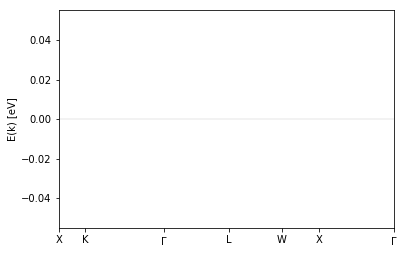

In [4]:
bandplotter = Matplot(data)

def plot(mask_bands, mask_characters, mask_groups, spin, unfolding_weight_exponent, 
         isCharacterPlot, ax, ignore_atoms_per_group=False, marker_size=1):
    alpha=1
    if isCharacterPlot:
        bandplotter.bands_two_characters(mask_bands, mask_characters, mask_groups, spin, unfolding_weight_exponent, 
                                         ax, alpha, ignore_atoms_per_group, marker_size)
    else:
        bandplotter.bands(mask_bands, mask_characters, mask_groups, spin, unfolding_weight_exponent, 
                          ax, alpha, ignore_atoms_per_group, marker_size)
        

### Define user input arguments

In [5]:
# bands = atom_group_keys = e.g. for banddos.hdf: dict_keys[(1,2,3,4,5)]
#                           Hm... should better convert to tuple back in reader?
def_groups = data.atoms_group_keys
select_groups = widgets.SelectMultiple(options=def_groups, 
                                   value=tuple(def_groups),
                                  description='Atom Groups',
                                  disabled=False)


def_characters = ['s', 'p', 'd', 'f']
# Characters = namedtuple('Characters', ['s', 'p', 'd', 'f'])
# characters = Characters(0,1,2,3)
select_characters = widgets.SelectMultiple(options=def_characters,
                                          value=tuple(def_characters),
                                          description='Band Character',
                                          disabled=False)

# number of bands can be large, so use a rangeslider instead of selectionslider
def_bands = [band for band in range(data.eigenvalues.shape[2])]
select_bands = widgets.IntRangeSlider(value=[def_bands[0]+1,def_bands[-1]+1], 
                                      min=def_bands[0]+1, max=def_bands[-1]+1, step=1,
                                     description='Bands',
                                     disabled=False, continuous_update=False,
                                     orientation='horizontal', readout=True,
                                     readout_format='d')

select_exponent = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=4.0,
    step=0.01,
    description='Unfolding weight exponent',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f')

select_marker_size = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=10.0,
    step=0.01,
    description='Marker size',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f')

select_compare_characters = widgets.Checkbox(
    value=False,
    description="Compare 2 characters (disabled)",
    disabled=True
)

# make compare_characters only available when 2 characters are selected
def on_character_selection_change(change):
    if len(change.new) == 2:
        select_compare_characters.disabled = False
        select_compare_characters.description = "Compare 2 characters (enabled)"
    else:
        select_compare_characters.disabled = True
        select_compare_characters.description = "Compare 2 characters (disabled)"
select_characters.observe(on_character_selection_change, names='value')

# when compare_characters is active, disable select_characters
def on_compare_character(change):
    select_characters.disabled = change.new
select_compare_characters.observe(on_compare_character, names='value')

## Interact function

In [8]:
fig_scale = 0.8
fig_ratio = [10,6]
fig, ax = plt.subplots(1, figsize=[fig_scale * el for el in fig_ratio])
plt.suptitle(f"BandStructure of {filename}")


@interact(bands=select_bands, characters=select_characters, groups=select_groups, 
          unfolding_weight_exponent=select_exponent, marker_size=select_marker_size,
         compare_characters=select_compare_characters)
def update_plot(bands, characters, groups, 
                unfolding_weight_exponent, marker_size,
               compare_characters):
    ax.clear()
    
    # convert arguments to the expected format for code 181124
    bands_conved = range(bands[0]-1,bands[1])
    groups_conved = [el-1 for el in groups]
    characters_conved = [def_characters.index(el) for el in characters]

    # TODO: switch button for ignore_atoms_per_group
    ignore_atoms_per_group = True #default
    
    # convert arguments to the expected format for code 181212
    mask_characters = [el in characters for el in def_characters]
    mask_bands = [el in bands_conved for el in def_bands]
    mask_groups = [el in [el for el in groups] for el in def_groups]
    
    spin = 0
    
    plot(mask_bands, mask_characters, mask_groups, spin, 
         unfolding_weight_exponent, compare_characters, ax, ignore_atoms_per_group, marker_size)

FigureCanvasNbAgg()

interactive(children=(IntRangeSlider(value=(1, 387), continuous_update=False, description='Bands', max=387, mi…

In [22]:
import ipyvolume as ipv
atoms_coords = np.random.random((5,3))
x, y, z = atoms_coords.T

x, y, z = data.atoms_position.T




ipv.figure()
scatter = ipv.scatter(x,y,z, size=5, marker="sphere")
ipv.show()

In [28]:
int_range = widgets.IntSlider()
captiontest=widgets.Label("info on change")

 
def on_value_change(change):
    captiontest.value = f"{change.new}"
 
int_range.observe(on_value_change, names='value')
display(int_range, captiontest)

IntSlider(value=0)

Label(value='info on change')

In [22]:

caption = widgets.Label(value='The values of range1 and range2 are synchronized')
slider = widgets.IntSlider(min=-5, max=5, value=1, description='Slider')

def handle_slider_change(change):
    caption.value = str(change['new'])
#     caption.value = 'The slider value is ' + (
#         'negative' if change.new < 0 else 'nonnegative'
#     )

slider.observe(handle_slider_change, names='value')

display(caption, slider)



Label(value='The values of range1 and range2 are synchronized')

IntSlider(value=1, description='Slider', max=5, min=-5)